In [1]:
# !pip install tensorflow keras opencv-python

In [2]:
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import cv2
import numpy as np
import os

In [3]:
# Skapa en ImageDataGenerator med augmentering för träningsdata
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Skapa en ImageDataGenerator för valideringsdata utan augmentering
validation_datagen = ImageDataGenerator(rescale=1./255)

# Ladda träningsdata med augmentering
train_data = train_datagen.flow_from_directory(
    'data/train',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

# Ladda valideringsdata utan augmentering
validation_data = validation_datagen.flow_from_directory(
    'data/validation',
    target_size=(48, 48),
    color_mode='grayscale',
    batch_size=32,
    class_mode='categorical'
)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


In [4]:
# Skapa och kompilera den första modellen
model = Sequential([
    Conv2D(64, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Conv2D(512, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    Flatten(),
    Dense(256, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

# Skapa en Early Stopping-callback
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Träna modellen med Early Stopping
history = model.fit(train_data, 
                    epochs=100, 
                    validation_data=validation_data, 
                    callbacks=[early_stopper])

# Spara den första modellen
model.save('improved_emotion_detection_model.keras')


Epoch 1/100


C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


  1/901 ━━━━━━━━━━━━━━━━━━━━ 30:33 2s/step - accuracy: 0.1250 - loss: 1.9431

C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


901/901 ━━━━━━━━━━━━━━━━━━━━ 59s 63ms/step - accuracy: 0.2378 - loss: 1.8416 - val_accuracy: 0.2584 - val_loss: 1.8426
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.2442 - loss: 1.8108 - val_accuracy: 0.2656 - val_loss: 1.7840
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.2661 - loss: 1.7729 - val_accuracy: 0.3401 - val_loss: 1.6864
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.3107 - loss: 1.7049 - val_accuracy: 0.3731 - val_loss: 1.6210
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.3438 - loss: 1.6544 - val_accuracy: 0.4175 - val_loss: 1.5038
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.3845 - loss: 1.5754 - val_accuracy: 0.4516 - val_loss: 1.4441
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 65ms/step - accuracy: 0.4104 - loss: 1.5263 - val_accuracy: 0.4716 - val_loss: 1.3774
Epoch 8/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 58s 64ms/step - accuracy: 0.4278 - loss: 1.4816 - val_

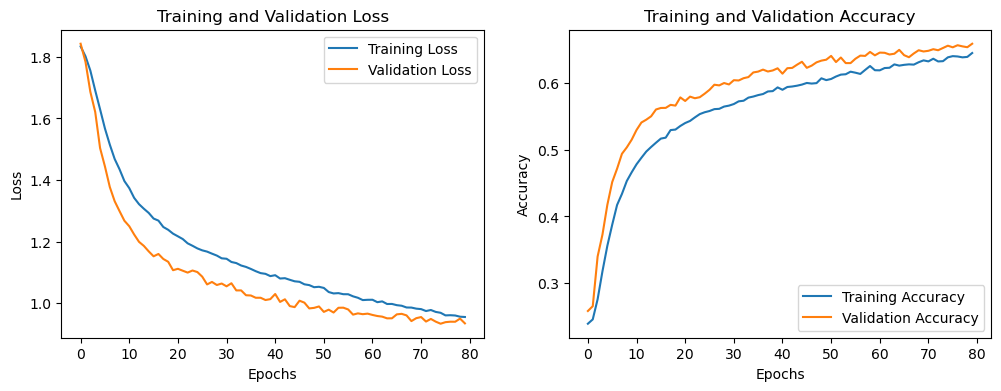

In [5]:
# Visualisera tränings- och valideringsförlust samt noggrannhet
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [6]:
# Skapa och kompilera en ny alternativ modell
alternative_model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(48, 48, 1)),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.3),

    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.4),

    # Lägg till Global Average Pooling direkt efter det fjärde Convolutional lagret
    GlobalAveragePooling2D(),

    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(7, activation='softmax')
])

alternative_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), 
                          loss='categorical_crossentropy', 
                          metrics=['accuracy'])

# Skapa en Early Stopping-callback
early_stopper = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Träna den alternativa modellen med Early Stopping
alternative_history = alternative_model.fit(train_data, 
                                            epochs=100, 
                                            validation_data=validation_data, 
                                            callbacks=[early_stopper])

# Spara den alternativa modellen
alternative_model.save('alternative_emotion_detection_model.keras')

Epoch 1/100


C:\Users\pauls\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


901/901 ━━━━━━━━━━━━━━━━━━━━ 27s 28ms/step - accuracy: 0.2315 - loss: 1.8630 - val_accuracy: 0.2583 - val_loss: 1.8767
Epoch 2/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2412 - loss: 1.8336 - val_accuracy: 0.2581 - val_loss: 1.8456
Epoch 3/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2469 - loss: 1.8103 - val_accuracy: 0.2611 - val_loss: 1.8116
Epoch 4/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2416 - loss: 1.8016 - val_accuracy: 0.2593 - val_loss: 1.8042
Epoch 5/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2502 - loss: 1.7917 - val_accuracy: 0.2644 - val_loss: 1.7874
Epoch 6/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2507 - loss: 1.7874 - val_accuracy: 0.2736 - val_loss: 1.7636
Epoch 7/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 26s 29ms/step - accuracy: 0.2650 - loss: 1.7692 - val_accuracy: 0.3098 - val_loss: 1.7285
Epoch 8/100
901/901 ━━━━━━━━━━━━━━━━━━━━ 27s 29ms/step - accuracy: 0.2823 - loss: 1.7444 - val_

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_4 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 2, 2, 256)      │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 1, 1, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 256)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           903 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,264,919 (4.83 MB)

 Trainable params: 421,639 (1.61 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 843,280 (3.22 MB)

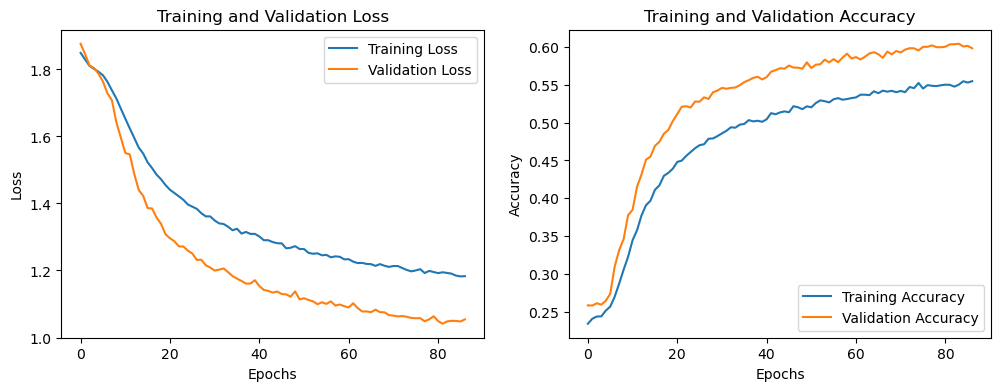

In [7]:
# Skriv ut en sammanfattning av den alternativa modellen
alternative_model.summary()

# Visualisera tränings- och valideringsresultaten för den alternativa modellen
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(alternative_history.history['loss'], label='Training Loss')
plt.plot(alternative_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(alternative_history.history['accuracy'], label='Training Accuracy')
plt.plot(alternative_history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [8]:
# Hämta prestandavärden för den första modellen
new_model = tf.keras.models.load_model('improved_emotion_detection_model.keras')
new_train_loss, new_train_accuracy = new_model.evaluate(train_data)
new_val_loss, new_val_accuracy = new_model.evaluate(validation_data)

# Hämta prestandavärden för den andra modellen
alt_train_loss, alt_train_accuracy = alternative_model.evaluate(train_data)
alt_val_loss, alt_val_accuracy = alternative_model.evaluate(validation_data)

# Skriv ut jämförelsen mellan de två modellerna
print("=== Comparison of Models ===")
print(f"First Model - Training Accuracy: {new_train_accuracy:.4f}, Training Loss: {new_train_loss:.4f}")
print(f"First Model - Validation Accuracy: {new_val_accuracy:.4f}, Validation Loss: {new_val_loss:.4f}")
print("----------------------------------------------------")
print(f"Second Model - Training Accuracy: {alt_train_accuracy:.4f}, Training Loss: {alt_train_loss:.4f}")
print(f"Second Model - Validation Accuracy: {alt_val_accuracy:.4f}, Validation Loss: {alt_val_loss:.4f}")

901/901 ━━━━━━━━━━━━━━━━━━━━ 23s 25ms/step - accuracy: 0.6834 - loss: 0.8448
221/221 ━━━━━━━━━━━━━━━━━━━━ 4s 19ms/step - accuracy: 0.6610 - loss: 0.9200
901/901 ━━━━━━━━━━━━━━━━━━━━ 16s 18ms/step - accuracy: 0.6011 - loss: 1.0578
221/221 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - accuracy: 0.5979 - loss: 1.0523
=== Comparison of Models ===
First Model - Training Accuracy: 0.6855, Training Loss: 0.8445
First Model - Validation Accuracy: 0.6558, Validation Loss: 0.9335
----------------------------------------------------
Second Model - Training Accuracy: 0.5961, Training Loss: 1.0662
Second Model - Validation Accuracy: 0.6036, Validation Loss: 1.0412


In [ ]:
# Ladda den förbättrade modellen
model = tf.keras.models.load_model('improved_emotion_detection_model.keras')

# Ordbok för att mappa klassindex till engelska känslor samt associerade färger
emotion_dict = {
    0: ('Angry', (0, 0, 255)),        # Röd
    1: ('Disgust', (0, 255, 0)),      # Grön
    2: ('Fear', (255, 255, 0)),       # Cyan
    3: ('Happy', (255, 255, 255)),    # Vit
    4: ('Sad', (255, 0, 0)),          # Blå
    5: ('Surprise', (0, 255, 255)),   # Gul
    6: ('Neutral', (128, 128, 128))   # Grå
}

# Starta webbkameran
cap = cv2.VideoCapture(0)

while True:
    ret, frame = cap.read()
    if not ret:
        break

    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    faces = face_cascade.detectMultiScale(gray, 1.3, 5)

    for (x, y, w, h) in faces:
        roi_gray = gray[y:y+h, x:x+w]
        roi_gray = cv2.resize(roi_gray, (48, 48))
        roi_gray = roi_gray / 255.0
        roi_gray = np.reshape(roi_gray, (1, 48, 48, 1))

        prediction = model.predict(roi_gray)
        emotion = np.argmax(prediction)

        emotion_label, color = emotion_dict[emotion]

        cv2.putText(frame, emotion_label, (x, y-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, color, 2)
        cv2.rectangle(frame, (x, y), (x+w, y+h), color, 2)

    cv2.imshow('Emotion Detector', frame)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
1/1 ━━━━━━━━